# Import libraries

In [292]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import time

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from eli5.sklearn import PermutationImportance
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB

RANDOM_SEED = 42

# Import data

**train.csv**: Personal records for about two-thirds (around 8700) of the passengers, to be used as training data.

**test.csv** - Personal records for the remaining one-third (around 4300) of the passengers, to be used as test data. 

  Your task is to predict the value of Transported for the passengers in this set.

> PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.


> HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.


> CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.


> Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.


> Destination - The planet the passenger will be debarking to.


> Age - The age of the passenger.


> VIP - Whether the passenger has paid for special VIP service during the voyage.


> RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.


> Name - The first and last names of the passenger.


> Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.




In [193]:
train = pd.read_csv('space_titanic_train.csv')
test = pd.read_csv('space_titanic_test.csv')

### Dataset preview

In [194]:
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head()

Train set shape: (8693, 14)
Test set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [195]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [196]:
train.nunique()

PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64

### Check data type

In [197]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Categorical columns preview

In [198]:
for i in train.columns:
  if train[i].dtypes == 'object':
    print(i)
    print(train[i].unique())
    print('-'*30)

PassengerId
['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
------------------------------
HomePlanet
['Europa' 'Earth' 'Mars' nan]
------------------------------
CryoSleep
[False True nan]
------------------------------
Cabin
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
------------------------------
Destination
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
------------------------------
VIP
[False True nan]
------------------------------
Name
['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Fayey Connon'
 'Celeon Hontichre' 'Propsh Hontichre']
------------------------------


### Numerical columns preview

In [199]:
for i in train.columns:
  if train[i].dtypes in ['int64','float64']:
    print(f'{i} min and max: {train[i].min()} , {train[i].max()}')
    print('-'*30)

Age min and max: 0.0 , 79.0
------------------------------
RoomService min and max: 0.0 , 14327.0
------------------------------
FoodCourt min and max: 0.0 , 29813.0
------------------------------
ShoppingMall min and max: 0.0 , 23492.0
------------------------------
Spa min and max: 0.0 , 22408.0
------------------------------
VRDeck min and max: 0.0 , 24133.0
------------------------------


### Check duplicate

In [200]:
print(f"Train duplicate: {train.duplicated().sum() / train.shape[0]}")
print(f"Test duplicate: {test.duplicated().sum() / test.shape[0]}")

Train duplicate: 0.0
Test duplicate: 0.0


### Check NaN

In [201]:
print('Train missing value')
print('-'*30)
train.isna().sum() / train.shape[0]

Train missing value
------------------------------


PassengerId     0.000000
HomePlanet      0.023122
CryoSleep       0.024963
Cabin           0.022892
Destination     0.020936
Age             0.020591
VIP             0.023352
RoomService     0.020821
FoodCourt       0.021051
ShoppingMall    0.023927
Spa             0.021051
VRDeck          0.021627
Name            0.023007
Transported     0.000000
dtype: float64

In [202]:
train.isnull().sum(axis = 1).value_counts() / train.shape[0]

0    0.759922
1    0.214771
2    0.023352
3    0.001956
dtype: float64

In [203]:
print('Test missing value')
print('-'*30)
test.isna().sum() / test.shape[0]

Test missing value
------------------------------


PassengerId     0.000000
HomePlanet      0.020341
CryoSleep       0.021744
Cabin           0.023381
Destination     0.021510
Age             0.021277
VIP             0.021744
RoomService     0.019172
FoodCourt       0.024784
ShoppingMall    0.022913
Spa             0.023615
VRDeck          0.018705
Name            0.021978
dtype: float64

In [204]:
test.isnull().sum(axis = 1).value_counts() / test.shape[0]

0    0.767126
1    0.205518
2    0.026420
3    0.000935
dtype: float64

### Missing Value Observation
- There are little missing values in each columns but they are independent.
- Test data also got missing values so instead of dropping data, we should fill each column with something. 
> I suggest Mode for categorical columns and Mean for Numerical columns.







# EDA

### Check target distribution

In [159]:
train.Transported.value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

Target distribution not imbalance.

### Categorical Columns EDA

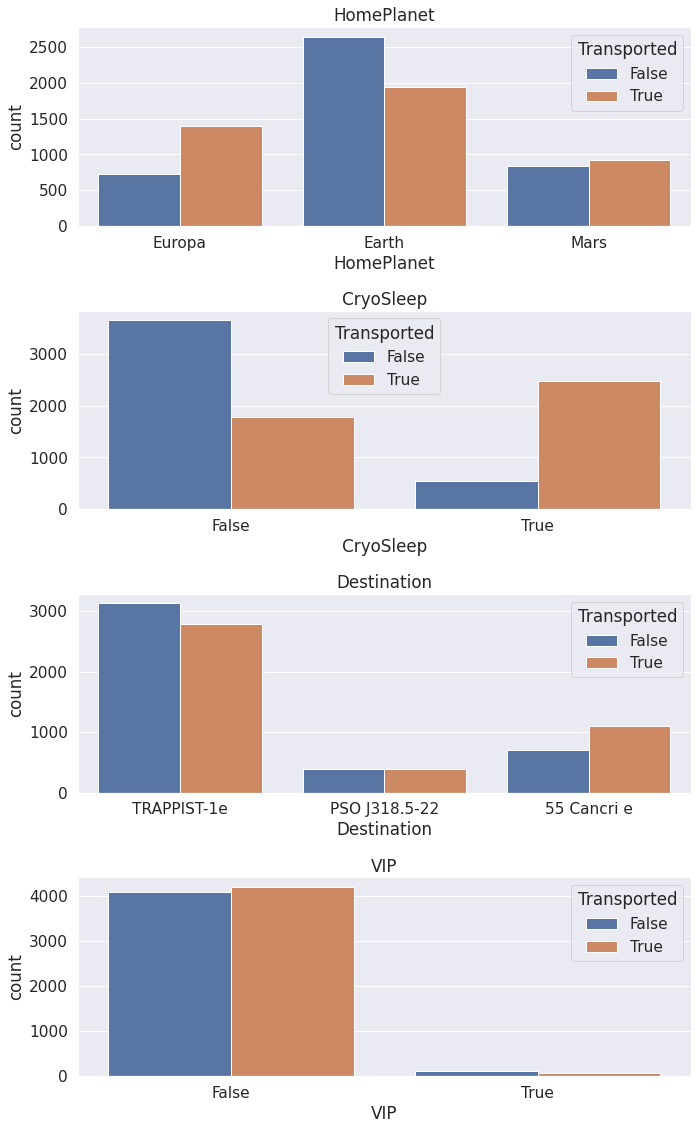

In [73]:
# Categorical features
cat_cols=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_cols):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

### Categorical columns key observation
- Passengers from Europa and Earth transported more than Mars.
- Most of cryo sleep passengers transported to another dimension.
- Passenger who has destination at 55 Cancri e got better chance to transport.
- VIP aren't good factor to consider about getting transport.

### Numerical Columns EDA

Text(0.5, 0, 'Age (years)')

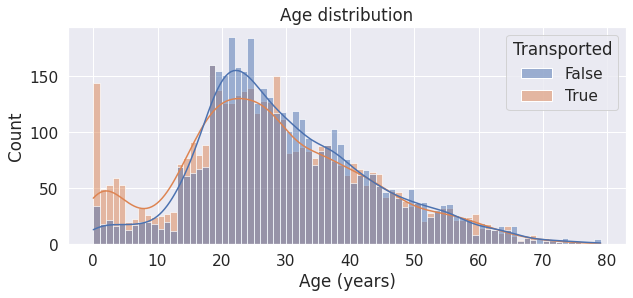

In [30]:
# Age
plt.figure(figsize=(10,4))

sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

plt.title('Age distribution')
plt.xlabel('Age (years)')

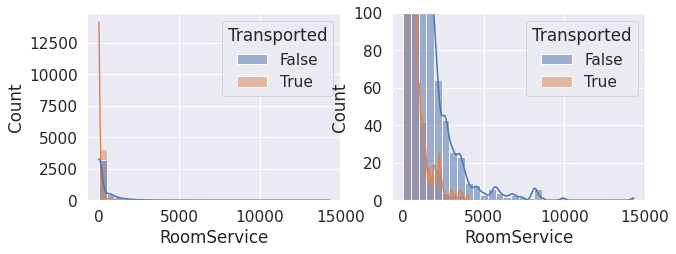

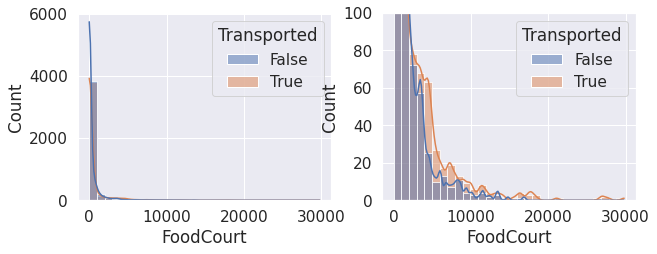

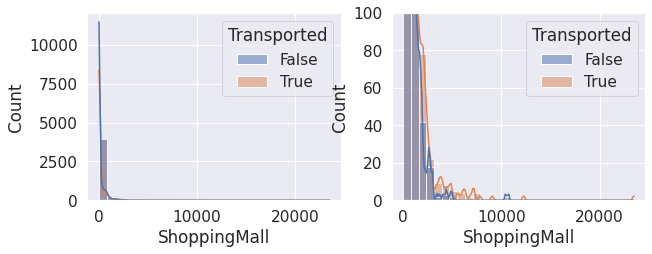

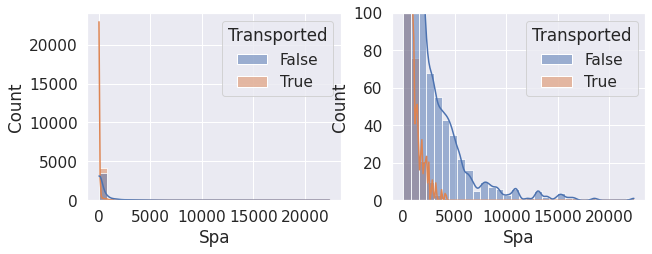

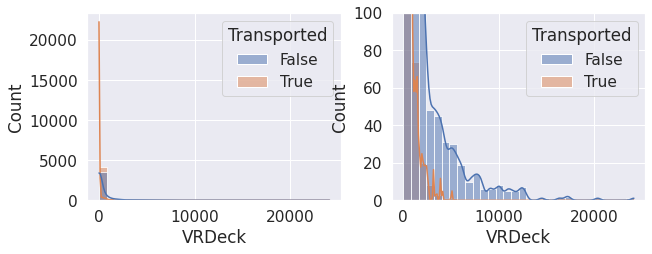

In [49]:
# Numerical features
float_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for col in float_cols:
  fig=plt.figure(figsize=(10,20))

  ax=fig.add_subplot(5,2,1)
  sns.histplot(data=train, x=col, axes=ax, bins=30, kde=True, hue='Transported')
  ax=fig.add_subplot(5,2,2)
  sns.histplot(data=train, x=col, axes=ax, bins=30, kde=True, hue='Transported')
  plt.ylim([0,100])

  plt.xlabel(f'{col}')
  plt.show()

### Numerical columns key observation
- A lot of young age passengers transported to another dimension.
- Passenger who transported to another dimension has little to no bill payment.
- Data is so skew.
- There are outlier in our data.

### Correlation

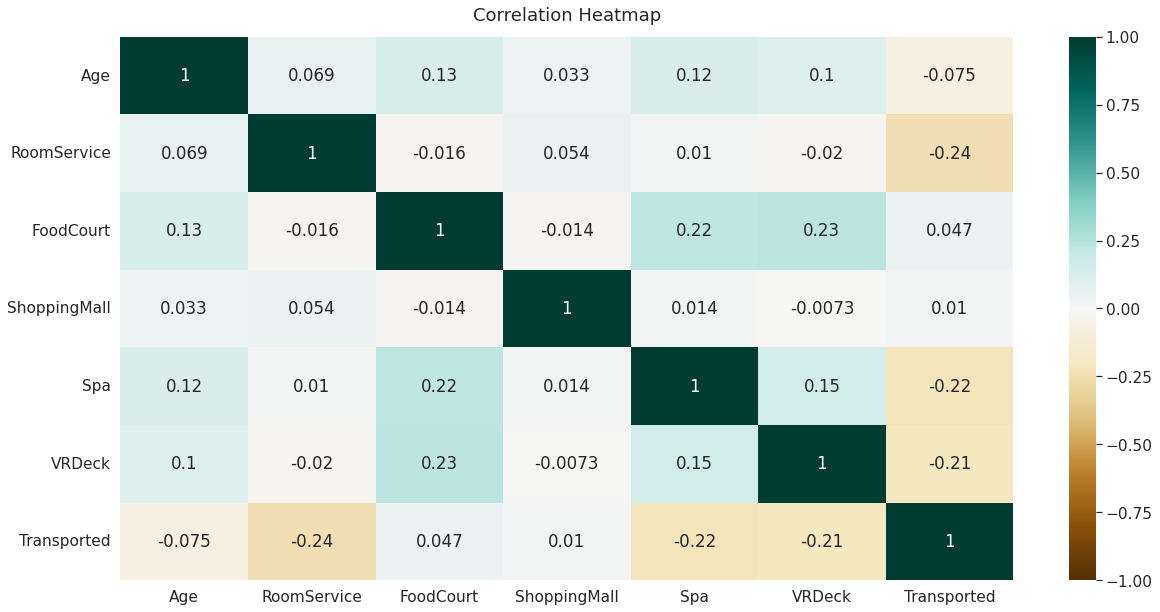

In [54]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Data got no big correlation to be worry.

# Feature Engineering
- Add feature that check if passenger buy anything or not
- Add feature that sum all bill payment of passenger

In [205]:
train['SumBillPayment']=train[float_cols].sum(axis=1)
train['SpendOrNot']=(train['SumBillPayment']==0).astype(int)

# Preprocessing
### Deal with missing values
- Fill numerical columns with Train Mean
- FIll categorical columns with Train Mode

### Data Wrangling
- Transform numerical columns to remove skewness
- One-hot encode categorical columns

In [259]:
# Because this is a test so I want to show performance result in this notebook
# That's why I created test set from train set because it have a target for calculate accuracy
to_drop = ['Transported', 'Name','PassengerId','Cabin']

X = train.drop(to_drop, axis =1)
y = train[['Transported']]

X_train , X_test , y_train , y_test = train_test_split(X, 
                                                       y, 
                                                       random_state = RANDOM_SEED,
                                                       test_size =0.10)

### Deal with missing values

In [260]:
for col in cat_cols:
  mode = X_train[col].mode()[0]
  X_train[col].fillna(mode, inplace=True)
  X_test[col].fillna(mode, inplace=True)

In [261]:
for col in float_cols:
  X_train[col] = X_train[col].fillna(X_train[col].mean())
  X_test[col] = X_test[col].fillna(X[col].mean())

In [262]:
age_mode = X_train['Age'].mode()[0]
X_train['Age'] = X_train['Age'].fillna(age_mode)
X_test['Age'] = X_test['Age'].fillna(age_mode)

In [263]:
print('Train Missing Value')
print('-'*30)
X_train.isna().sum()

Train Missing Value
------------------------------


HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
SumBillPayment    0
SpendOrNot        0
dtype: int64

In [264]:
print('Test Missing Value')
print('-'*30)
X_test.isna().sum()

Test Missing Value
------------------------------


HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
SumBillPayment    0
SpendOrNot        0
dtype: int64

In [265]:
for i in X_train.columns:
  if X_train[i].dtypes == 'object':
    print(i)
    print(X_train[i].unique())
    print('-'*30)

HomePlanet
['Mars' 'Europa' 'Earth']
------------------------------
Destination
['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22']
------------------------------


In [266]:
for i in X_train.columns:
  if X_train[i].dtypes in ['int64','float64']:
    print(f'{i} min and max: {X_train[i].min()} , {X_train[i].max()}')
    print('-'*30)

Age min and max: 0.0 , 79.0
------------------------------
RoomService min and max: 0.0 , 14327.0
------------------------------
FoodCourt min and max: 0.0 , 29813.0
------------------------------
ShoppingMall min and max: 0.0 , 23492.0
------------------------------
Spa min and max: 0.0 , 22408.0
------------------------------
VRDeck min and max: 0.0 , 24133.0
------------------------------
SumBillPayment min and max: 0.0 , 35987.0
------------------------------
SpendOrNot min and max: 0 , 1
------------------------------


In [267]:
X_train['VIP'].unique()

array([False,  True])

In [268]:
X_train['CryoSleep'].unique()

array([False,  True])

### Log Transform Data
If your variable is skewed, high values will affect the variances and push your split points towards higher values - forcing your decision tree to make less balanced splits and trying to "isolate" the tail from the rest of the points.

https://stats.stackexchange.com/questions/447863/log-transforming-target-var-for-training-a-random-forest-regressor

In [269]:
for col in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','SumBillPayment']:
    X_train[col] = np.log(1+X_train[col])
    X_test[col] = np.log(1+X_test[col])

### One-hot encode categorical column
To use categorical features in model we need to encode it and all of our categorical features are not ordinal so we can use one-hot.

In [270]:
CryoSleep_labels = {False: 0, True: 1}
X_train.CryoSleep = X_train.CryoSleep.replace(CryoSleep_labels)
X_test.CryoSleep = X_test.CryoSleep.replace(CryoSleep_labels)

In [271]:
VIP_labels = {False: 0, True: 1}
X_train.VIP = X_train.VIP.replace(VIP_labels)
X_test.VIP = X_test.VIP.replace(VIP_labels)

In [272]:
X_train = pd.get_dummies(X_train, columns = ['HomePlanet', 'Destination'])
X_test = pd.get_dummies(X_test, columns = ['HomePlanet', 'Destination'])

In [274]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7823 entries, 1432 to 7270
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  7823 non-null   int64  
 1   Age                        7823 non-null   float64
 2   VIP                        7823 non-null   int64  
 3   RoomService                7823 non-null   float64
 4   FoodCourt                  7823 non-null   float64
 5   ShoppingMall               7823 non-null   float64
 6   Spa                        7823 non-null   float64
 7   VRDeck                     7823 non-null   float64
 8   SumBillPayment             7823 non-null   float64
 9   SpendOrNot                 7823 non-null   int64  
 10  HomePlanet_Earth           7823 non-null   uint8  
 11  HomePlanet_Europa          7823 non-null   uint8  
 12  HomePlanet_Mars            7823 non-null   uint8  
 13  Destination_55 Cancri e    7823 non-null   ui

In [273]:
# Print new shape
print(f'Training set shape: {X_train.shape}')
print(f'Testing set shape: {X_test.shape}')
X_train.head()

Training set shape: (7823, 16)
Testing set shape: (870, 16)


,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,SumBillPayment,SpendOrNot,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
1432,0,31.0,0,7.112327,0.000000,0.693147,0.000000,0.000000,7.113142,0,0,0,1,0,0,1
6858,0,26.0,0,0.000000,6.799056,0.000000,6.538140,0.693147,7.370231,0,0,1,0,0,0,1
4436,1,24.0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,0,0,1
7230,0,33.0,0,0.000000,0.000000,0.000000,6.079933,5.416100,6.493754,0,1,0,0,1,0,0
2992,0,21.0,0,7.001246,0.000000,4.394449,6.380123,0.000000,7.477038,0,0,0,1,0,0,1


# Modelling
I choose LightGBM from the start because I like boosting tree algorithm due to how easy to tune it for good performance, consistent and it can train very fast so it's perfect for me in this time limit test.

### Hyperparameters tuning with GridSearchCV
I choose this method because it is fast and give us the best combination of hyperparameters.

In [280]:
boosted_grid = {
        'n_estimators': [10, 25 ,50, 100, 125, 150, 175, 200],
        'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
        'learning_rate': [0.005, 0.01, 0.025, 0.05,0.075, 0.1, 0.15]
        }

In [281]:
start = time.time()
clf = GridSearchCV(estimator=LGBMClassifier(random_state=RANDOM_SEED), param_grid=boosted_grid, n_jobs=-1, cv=10)

# Train and score
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))

# Save trained model
print(clf.best_params_)

# Print iteration and training time
stop = time.time()
print(f"time use: {np.round((stop - start)/60, 2)}")

0.8284545570752908
{'learning_rate': 0.075, 'max_depth': 6, 'n_estimators': 100}
time use: 14.67


In [287]:
X_train.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'SumBillPayment', 'SpendOrNot', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'],
      dtype='object')

### Use Stratified K-Fold Cross Validation for better performance in predicting test set

In [285]:
FOLDS = 10
lgb_params = {
    'objective' : 'binary',
    'n_estimators' :100,
    'learning_rate' : 0.075,
    'max_depth': 6
}

lgb_predictions = 0
lgb_scores = []
lgb_scores_f1 = []
lgb_fimp = []
LGBM_FEATURES = list(X_train.columns)
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=RANDOM_SEED)
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    print(f'\033[94m')
    print(10*"=", f"Fold={fold+1}", 10*"=")
    start_time = time.time()
    
    X_train2, X_valid = X_train.iloc[train_idx][LGBM_FEATURES], X_train.iloc[valid_idx][LGBM_FEATURES]
    y_train2 , y_valid = y_train.iloc[train_idx] , y_train.iloc[valid_idx]
    
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train2, y_train2,verbose=0)
    
    preds_valid = model.predict(X_valid)
    acc = accuracy_score(y_valid,  preds_valid)
    f1 = f1_score(y_valid,  preds_valid)
    lgb_scores.append(acc)
    lgb_scores_f1.append(f1)
    run_time = time.time() - start_time
    
    fim = pd.DataFrame(index=LGBM_FEATURES,
                 data=model.feature_importances_,
                 columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    
    print(f"Fold={fold+1}, Accuracy score: {acc:.2f}%, F1 score: {f1:.2f}%, Run Time: {run_time:.2f}s")
    test_preds = model.predict(X_test) 
    lgb_predictions += test_preds/FOLDS
print("")
print(f"Mean Accuracy : {np.mean(lgb_scores)}")
print(f"Mean F1: {np.mean(lgb_scores_f1)}")


========== Fold=1 ==========
Fold=1, Accuracy score: 0.79%, F1 score: 0.80%, Run Time: 0.17s

========== Fold=2 ==========
Fold=2, Accuracy score: 0.81%, F1 score: 0.82%, Run Time: 0.17s

========== Fold=3 ==========
Fold=3, Accuracy score: 0.82%, F1 score: 0.83%, Run Time: 0.94s

========== Fold=4 ==========
Fold=4, Accuracy score: 0.78%, F1 score: 0.79%, Run Time: 1.60s

========== Fold=5 ==========
Fold=5, Accuracy score: 0.79%, F1 score: 0.79%, Run Time: 0.18s

========== Fold=6 ==========
Fold=6, Accuracy score: 0.81%, F1 score: 0.82%, Run Time: 0.16s

========== Fold=7 ==========
Fold=7, Accuracy score: 0.79%, F1 score: 0.80%, Run Time: 0.17s

========== Fold=8 ==========
Fold=8, Accuracy score: 0.83%, F1 score: 0.83%, Run Time: 0.16s

========== Fold=9 ==========
Fold=9, Accuracy score: 0.78%, F1 score: 0.79%, Run Time: 0.16s

========== Fold=10 ==========
Fold=10, Accuracy score: 0.80%, F1 score: 0.81%, Run Time: 0.17s

Mean Accuracy : 0.7998193713600716
Mean F1: 0.80758945889

# Result

### Features Importance

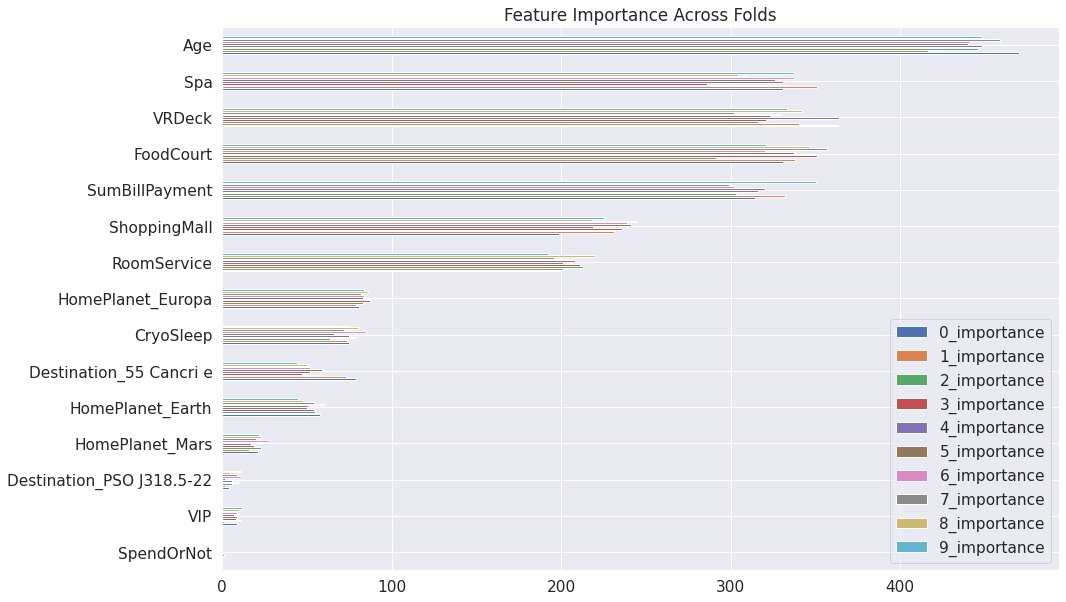

In [286]:
lgbm_fis_df = pd.concat(lgb_fimp, axis=1).head(15)
lgbm_fis_df.sort_values('1_importance').plot(kind='barh', figsize=(15, 10),
                                       title='Feature Importance Across Folds')
plt.show()

### Test Score

In [290]:
prediction = lgb_predictions.astype("bool")
test_acc = accuracy_score(y_test, prediction)
test_f1 = f1_score(y_test, prediction)

print(f"Test Accuracy : {test_acc:.3f}")
print(f"Test F1: {test_f1:.3f}")

Test Accuracy : 0.776
Test F1: 0.792


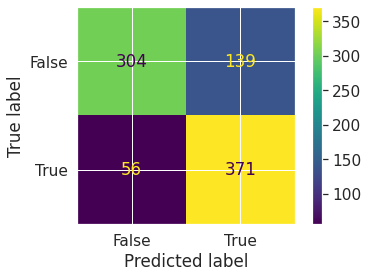

In [295]:
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()